In [1]:
import os

import numpy as np
import pandas as pd

In [2]:
import time
import torch
import torchvision
from glob import glob
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader,Dataset
from torchvision.utils import make_grid

from nets import SimpleSegmentationNet
from data import CityscapesDataset

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# Print the current process ID
print("Current Process ID:", os.getpid())

Current Process ID: 2111490


In [5]:
# file_paths = glob('/cluster/projects/vc/data/ad/open/Cityscapes/gtFine_trainvaltest/gtFine/train/bremen/**/*', recursive=True)
train_seg_path = sorted(glob('/cluster/projects/vc/data/ad/open/Cityscapes/gtFine_trainvaltest/gtFine/train/*/*labelIds.png'))
train_img_path = sorted(glob('/cluster/projects/vc/data/ad/open/Cityscapes/leftImg8bit_trainvaltest/leftImg8bit/train/*/*.png'))

val_seg_path = sorted(glob('/cluster/projects/vc/data/ad/open/Cityscapes/gtFine_trainvaltest/gtFine/val/*/*labelIds.png'))
val_img_path = sorted(glob('/cluster/projects/vc/data/ad/open/Cityscapes/leftImg8bit_trainvaltest/leftImg8bit/val/*/*.png'))

test_seg_path = sorted(glob('/cluster/projects/vc/data/ad/open/Cityscapes/gtFine_trainvaltest/gtFine/test/bielefeld/*labelIds.png'))
test_img_path = sorted(glob('/cluster/projects/vc/data/ad/open/Cityscapes/leftImg8bit_trainvaltest/leftImg8bit/test/bielefeld/*.png'))

In [6]:
print(len(train_seg_path))
print(len(train_img_path))

2975
2975


fig,ax = plt.subplots(5,2,figsize=(10,30))
for i in range(5):
    img1 = plt.imread(test_seg_path[i])
    img2 = plt.imread(test_img_path[i])
    print(test_seg_path[i])
    ax[i][0].imshow(img1)
    ax[i][1].imshow(img2)

## Dataset and dataloader

In [7]:
traindata = CityscapesDataset(train_img_path, train_seg_path)
valdata = CityscapesDataset(val_img_path, val_seg_path)
# testdata = CityscapesDataset(test_img_path, test_seg_path)

In [8]:
batch_size = 4
train_loader = DataLoader(traindata, batch_size)
val_loader = DataLoader(valdata, batch_size)
# test_loader = DataLoader(testdata, batch_size)

## Testing the dataloader

data = next(iter(train_loader))

len(data)
print(data[0].size())

fig,ax = plt.subplots(4,2,figsize=(10,30))
for i in range(4):
    img_raw = data[0][i].squeeze().permute((1, 2, 0))
    img_labels = data[1][i].squeeze()
    ax[i][0].imshow(img_raw)
    ax[i][1].imshow(img_labels)

## Neural network

In [9]:
from labels import labels

In [10]:
num_classes = len(labels)
model = SimpleSegmentationNet(num_classes)
model.to(device)

SimpleSegmentationNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (up2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (out_conv): Conv2d(64, 35, kernel_size=(1, 1), stride=(1, 1))
)

## Training

In [11]:
def show(img, output, label):
    img, output, label = img.cpu(), output.cpu(), label.cpu()
    fig, ax = plt.subplots(len(img), 3, figsize=(15, 30))
    cols = ['Input Image', 'Actual Output', 'Predicted Output']
    
    for x, col in zip(ax[0], cols):
        x.set_title(col)

    for i in range(len(img)):
        Img = img[i].permute(1, 2, 0)
        Lab = output[i].squeeze()  # Assuming output is a segmentation map
        act = label[i].squeeze()  # Assuming label is a segmentation map
        
        ax[i][0].imshow(Img)
        ax[i][1].imshow(act, cmap='tab20')  # Apply a colormap suitable for labels
        ax[i][2].imshow(Lab, cmap='tab20')  # Apply the same colormap to predictions

    plt.tight_layout()
    plt.show()

In [12]:
lr = 0.01
epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [13]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
val_accuracy = []

In [14]:
checkpoint_dir = "checkpoints/cnn"
os.makedirs(checkpoint_dir, exist_ok=True)

for i in range(epochs):
    
    model.train()
    trainloss = 0
    
    for data in train_loader:
        # Training
        img, label = data[0].to(device), data[1].to(device)
        label = label.squeeze(1).to(dtype=torch.long)
        optimizer.zero_grad()

        output = model(img)
        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        trainloss += loss.item()

    train_loss.append(trainloss / len(train_loader))    
    
    model.eval()

    with torch.no_grad():
        valloss = 0
        total_correct = 0
        total_pixels = 0
        
        for data in val_loader:
            # Validation
            img, label = data[0].to(device), data[1].to(device)
            label = label.squeeze(1).to(dtype=torch.long)
            output = model(img)
            loss = criterion(output, label)
            valloss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(output.data, 1)
            total_correct += (predicted == label).sum().item()
            total_pixels += label.nelement()

        # show(img, predicted.unsqueeze(1), label)

    val_loss.append(valloss / len(val_loader))
    val_accuracy.append(total_correct / total_pixels)
    
    print("Epoch: {} , Train Loss: {} , Valid Loss: {} , Valid Acc: {:.2f}%".format(i, train_loss[-1], val_loss[-1], 100 * val_accuracy[-1]))

    if i%20 == 0:
         # Checkpointing
        checkpoint = {
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy
        }
        torch.save(checkpoint, os.path.join(checkpoint_dir, f'checkpoint_epoch_{i}.pth'))

KeyboardInterrupt: 

## Ploting the Training VS Validation Loss Curve

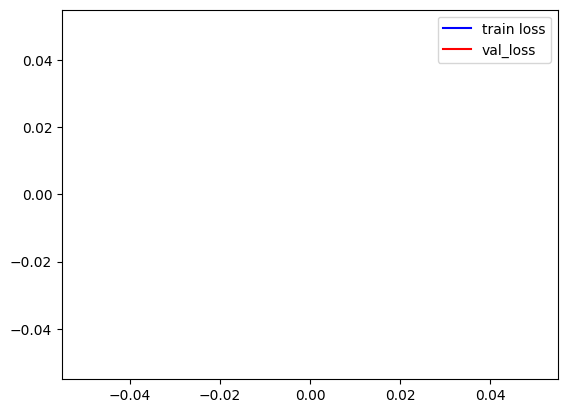

In [ ]:
plt.plot(train_loss,color='b',label='train loss')
plt.plot(val_loss,color='r',label = 'val_loss')
plt.legend()

## Testing on testset

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    total_time = 0
    
    for data in test_loader:
        image, label = data[0].to(device), data[1].to(device)
        label = label.squeeze(1).to(dtype=torch.long)

        # Start timer
        start_time = time.time()

        output = model(image)
        
        # End timer
        end_time = time.time()
        total_time += end_time - start_time

        # Get predictions from the maximum value
        _, predicted = torch.max(output.data, 1)
        total += label.nelement()
        correct += (predicted == label).sum().item()

accuracy = 100 * correct / total
print('Accuracy of the model on the test images: {:.2f}%'.format(accuracy))

# Calculate FPS
# Here, 'total' is the total number of images processed
fps = total / total_time
print('Inference speed: {:.2f} FPS'.format(fps))

## Visualizing the results

c = 0
with torch.no_grad():
    for img,label in (test_loader):
            img = img.to(device)
            label = label.to(device)
            output = model(img)
            _, predicted = torch.max(output.data, 1)
            show(img, predicted.unsqueeze(1), label)

            if c>5:
                break
            c+=1